# Tarea #4 Morfología

##Integrantes

* Gabriela María Castro Beltrán
* Juan Nicolas Carvajal Useche


Primero, se importan las librerías e imágenes requeridas para el desarrollo del taller.

In [ ]:
# Importar librerias
import os
import cv2
import matplotlib
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.multiarray import dtype
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import scipy.ndimage.morphology as m
from pylab import *
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from scipy import ndimage

# Importar imágenes
#img = cv2.imread("pare.jpg", cv2.IMREAD_COLOR)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


<ipython-input-2-665b70f12adf>:9: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
<ipython-input-2-665b70f12adf>:10: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


#Algoritmo de dilatación direccional

## Elementos estructurales según la dirección

El primer paso es crear las matrices con los elementos estructurantes de la dilatación para cada dirección

In [ ]:
# Elementos estructurantes
E= np.array([[0, 0, 0],[0, 1, 1],[0, 0, 0]], dtype=np.uint8)
NE= np.array([[0, 0, 1],[0, 1, 0],[0, 0, 0]], dtype=np.uint8)
N= np.array([[0, 1, 0],[0, 1, 0],[0, 0, 0]], dtype=np.uint8)
NW= np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0]], dtype=np.uint8)
W= np.array([[0, 0, 0],[1, 1, 0],[0, 0, 0]], dtype=np.uint8)
SW= np.array([[0, 0, 0],[0, 1, 0],[1, 0, 0]], dtype=np.uint8)
S= np.array([[0, 0, 0],[0, 1, 0],[0, 1, 0]], dtype=np.uint8)
SE= np.array([[0, 0, 0],[0, 1, 0],[0, 0, 1]], dtype=np.uint8)


Ahora, se implementa el algoritmo, primero se escribe como función la fórmula de dilatación direccional vista en clase

In [ ]:
#función de dilatación direccional
def calculaD(alpha,beta,d,a1,a2):
  D = float(beta*a1*a2*math.exp(-(d**2)/(alpha**2)))
  return D

La siguiente función aplica la dilatación con el elemento estructurante deseado y en un número de iteraciones determinadas por la ecuación de dilatación direccional y los parámetros de intervalos vistos en clase. Esta función dilata solo un objeto según el contorno de entrada

In [ ]:
def dilateObject(imagen,contornos,kernel,it,i):
  it=it*3
  gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY) #A escala de grises

  ret, th= cv2.threshold(gray,  240, 255, cv2.THRESH_BINARY_INV) #se umbraliza la imagen y se guarda en th
  imr = np.zeros((imagen.shape[0], imagen.shape[1]), np.uint8)
  ##Para dilatar un objeto de una imagen
  # Crear una máscara del mismo tamaño que la imagen, inicializada a ceros
  mask1 = np.zeros((imagen.shape[0], imagen.shape[1]), np.uint8)
  mask1 = cv2.drawContours(mask1,contornos,i,255, -1) #dibujar los contornos de la región de interés

  #Se dilata la imagen umbralizada, la máscara y la imagen original
  dilate_th = cv2.dilate(th, kernel, iterations=it)
  dilate_mask = cv2.dilate(mask1, kernel, iterations=it)

  # Retener la región de interés en una imagen por separado
  im1 = cv2.bitwise_and(dilate_th, dilate_mask)

  # El complemento de la región de interés
  dilate_mask_inv = cv2.bitwise_not(dilate_mask)
  im2 = cv2.bitwise_and(th, dilate_mask_inv)

  #se suma la región de interés dilatada con la imagen original
  res = cv2.add(im1, im2)
  return res

Para el algoritmo es requerido calcular las propiedades de centroide y área. Esto se hizo hallando los momentos de área usando la función cv2.moments, donde se generan los momentos de un contorno específico (i), luego, se halla el centroide en x y en y y se van almacenando en vectores, luego se calculan las áreas usando cv2.contourArea y de la misma manera se van guardando cada valor de cada objeto en un arreglo en cada iteración.

In [ ]:
#recorre la imagen y extrae los centroides y áreas de cada objeto
def centroide_area(contornos,imagen):
  #inicialización de variables de la función de dilatación direccional
  cXa = zeros(len(contornos))
  cYa = zeros(len(contornos))
  areaA = zeros(len(contornos))
  perA = zeros(len(contornos))

  for i in range(len(contornos)):
    cnt=contornos[i]
    M=cv2.moments(cnt)
    cX=int(M["m10"]/M["m00"])
    cXa[i]=cX
    cY=int(M["m01"]/M["m00"])
    cYa[i]=cY
    area=cv2.contourArea(cnt)
    areaA[i] = area
    perimetro=cv2.arcLength(cnt, True)
    perA[i] = perimetro

    #También se dibujan cuadrados envolventes de los objetos y puntos que muestren los centroides de cada objeto y su valor,
    #luego se imprime esta imagen, esto con único fin de ayuda visual y verificación del algoritmo

    cv2.circle(imagen, (cX, cY),5, (0,255,0),-1)
    cv2.putText(imagen, "x: "+str (cX)+", y: "+str (cY), (cX, cY),1,1, (0,0,0),1)
    x,y,w,h=cv2.boundingRect(cnt)
    cv2.rectangle(imagen,(x, y),(x+w, y+h), (0,255,0),3)
    #cv2.waitKey(0)

  plt.figure()
  plt.imshow(imagen,cmap='gray')
  plt.title("Imagen con los objetos y centroides identificados")
  return cXa,cYa,areaA

Ahora en esta función se aplica la dilatación direccional, recibiendo como parámetros los elementos para calcular la fórmula y la imagen. Se tienen dos ciclos anidados, con el fin de comparar cada objeto con los demás. El primer paso es inicializar las variables de dilatación en 0, luego, calcular los vectores que unen el centroide de un objeto con los demás, a este vector se le calcula el ángulo para determinar en qué dirección está el objeto, según este valor, el condicional if almacenará el valor de la función de dilatación direccional en la variable correspondiente, y así con cada objeto. Ya calculado todo esto, se normalizan respecto al valor máximo y posteriormente según el valor de cada dirección, se selecciona el número de iteraciones a dilatar en cada dirección. Luego se pasa al siguiente objeto y se repite este proceso hasta haberlo hecho con cada objeto detectado.

In [ ]:
def dilatacion_direc(cXa,cYa,areaA,contornos,imagen):
  alpha = 300.0
  beta = 2
  imr = np.zeros((imagen.shape[0], imagen.shape[1]), np.uint8) #Aquí se guarda la imagen resultante
  j = 0
  i = 0

  #ciclo para comparar cada objeto con los demás y determinar el valor de D
  while(i<=len(contornos)-1):
    j = 0

    #inicializar valores de la función en cada dirección
    DE = 0.0
    DNE = 0.0
    DN = 0.0
    DNW = 0.0
    DW = 0.0
    DSW = 0.0
    DS = 0.0
    DSE = 0.0

    while(j<=(len(contornos)-1)):
      di_k = ((cXa[i]-cXa[j])**2 + (cYa[i]-cYa[j])**2)**0.5 #vector de distancia entre los centroides del objeto i y un objeto k
      anglei_k = math.atan2((-cYa[i]+cYa[j]),(cXa[i]-cXa[j])) #ángulo de este vector (para determinar la región en hacia la que se debe dilatar)

      #super if que evalúa los 8 posibles casos de los valores del ángulo y suma el valor de "D" a la dirección correspondiente
      if (-pi/8<anglei_k<0 or 0<anglei_k<pi/8): #E
        DE =  DE + calculaD(alpha,beta,di_k,areaA[i],areaA[j])
      elif (pi/8<anglei_k<pi/8 + pi/4): #NE
        DNE =  DNE + calculaD(alpha,beta,di_k,areaA[i],areaA[j])
      elif (pi/8 + pi/4 <anglei_k< pi/8 + pi/2): #N
        DN =  DN + calculaD(alpha,beta,di_k,areaA[i],areaA[j])
      elif (pi/8 + pi/2 <anglei_k< pi/8 + pi/2 + pi/4): #NW
        DNW =  DNW + calculaD(alpha,beta,di_k,areaA[i],areaA[j])
      elif (pi/8 + pi/2 + pi/4  < anglei_k < pi or -pi  < anglei_k < -pi + pi/8): #W
        DW =  DW + calculaD(alpha,beta,di_k,areaA[i],areaA[j])
      elif (-pi+pi/8  < anglei_k < -pi+pi/8 + pi/4): #SW
        DSW =  DSW + calculaD(alpha,beta,di_k,areaA[i],areaA[j])
      elif (-pi + pi/8 + pi/4  < anglei_k < -pi+pi/8 + pi/2): #S
        DS =  DS + calculaD(alpha,beta,di_k,areaA[i],areaA[j])
      elif (-pi+pi/8 + pi/2  < anglei_k < -pi+pi/8 + pi/2 +pi/4): #SE
        DSE =  DSE + calculaD(alpha,beta,di_k,areaA[i],areaA[j])
      j+=1

    #Se normalizan los valores de 0 a 1
    maxv = np.max([DE,DNE,DN,DNW,DW,DSW,DS,DSE])
    DE,DNE,DN,DNW,DW,DSW,DS,DSE = DE/maxv,DNE/maxv,DN/maxv,DNW/maxv,DW/maxv,DSW/maxv,DS/maxv,DSE/maxv

    #Se evalúa el número de iteraciones de la dilatación en cada dirección y se ejecuta la dilatación, luego se guarda el resultado de la imagen

    if (0<DE<0.25): #E
      imr = cv2.add(imr,dilateObject(imagen,contornos,E,0,i))
    elif (0.25<DE<0.5):
      imr = cv2.add(imr,dilateObject(imagen,contornos,E,1,i))
    elif (0.5<DE<0.75):
      imr = cv2.add(imr,dilateObject(imagen,contornos,E,2,i))
    elif (0.75<DE<=1):
      imr = cv2.add(imr,dilateObject(imagen,contornos,E,3,i))

    if (0<DNE<0.25): #NE
      imr = cv2.add(imr,dilateObject(imagen,contornos,NE,0,i))
    elif (0.25<DNE<0.5):
      imr = cv2.add(imr,dilateObject(imagen,contornos,NE,1,i))
    elif (0.5<DNE<0.75):
      imr = cv2.add(imr,dilateObject(imagen,contornos,NE,2,i))
    elif (0.75<DNE<=1):
      imr = cv2.add(imr,dilateObject(imagen,contornos,NE,3,i))

    if (0<DN<0.25): #N
      imr = cv2.add(imr,dilateObject(imagen,contornos,N,0,i))
    elif (0.25<DN<0.5):
      imr = cv2.add(imr,dilateObject(imagen,contornos,N,1,i))
    elif (0.5<DN<0.75):
      imr = cv2.add(imr,dilateObject(imagen,contornos,N,2,i))
    elif (0.75<DN<=1):
      imr = cv2.add(imr,dilateObject(imagen,contornos,N,3,i))

    if (0<DNW<0.25): #NW
      imr = cv2.add(imr,dilateObject(imagen,contornos,NW,0,i))
    elif (0.25<DNW<0.5):
      imr = cv2.add(imr,dilateObject(imagen,contornos,NW,1,i))
    elif (0.5<DNW<0.75):
      imr = cv2.add(imr,dilateObject(imagen,contornos,NW,2,i))
    elif (0.75<DNW<=1):
      imr = cv2.add(imr,dilateObject(imagen,contornos,NW,3,i))

    if (0<DW<0.25): #W
      imr = cv2.add(imr,dilateObject(imagen,contornos,W,0,i))
    elif (0.25<DW<0.5):
      imr = cv2.add(imr,dilateObject(imagen,contornos,W,1,i))
    elif (0.5<DW<0.75):
      imr = cv2.add(imr,dilateObject(imagen,contornos,W,2,i))
    elif (0.75<DW<=1):
      imr = cv2.add(imr,dilateObject(imagen,contornos,W,3,i))

    if (0<DSW<0.25): #SW
      imr = cv2.add(imr,dilateObject(imagen,contornos,SW,0,i))
    elif (0.25<DSW<0.5):
      imr = cv2.add(imr,dilateObject(imagen,contornos,SW,1,i))
    elif (0.5<DSW<0.75):
      imr = cv2.add(imr,dilateObject(imagen,contornos,SW,2,i))
    elif (0.75<DSW<=1):
      imr = cv2.add(imr,dilateObject(imagen,contornos,SW,3,i))

    if (0<DS<0.25): #S
      imr = cv2.add(imr,dilateObject(imagen,contornos,S,0,i))
    elif (0.25<DS<0.5):
      imr = cv2.add(imr,dilateObject(imagen,contornos,S,1,i))
    elif (0.5<DS<0.75):
      imr = cv2.add(imr,dilateObject(imagen,contornos,S,2,i))
    elif (0.75<DS<=1):
      imr = cv2.add(imr,dilateObject(imagen,contornos,S,3,i))

    if (0<DSE<0.25): #SE
      imr = cv2.add(imr,dilateObject(imagen,contornos,SE,0,i))
    elif (0.25<DSE<0.5):
      imr = cv2.add(imr,dilateObject(imagen,contornos,SE,1,i))
    elif (0.5<DSE<0.75):
      imr = cv2.add(imr,dilateObject(imagen,contornos,SE,2,i))
    elif (0.75<DSE<=1):
      imr = cv2.add(imr,dilateObject(imagen,contornos,SE,3,i))

    i+=1

  return imr

Acá aplicamos el algoritmo a la imagen cargada

Text(0.5, 1.0, 'Imagen dilatada umbralizada')

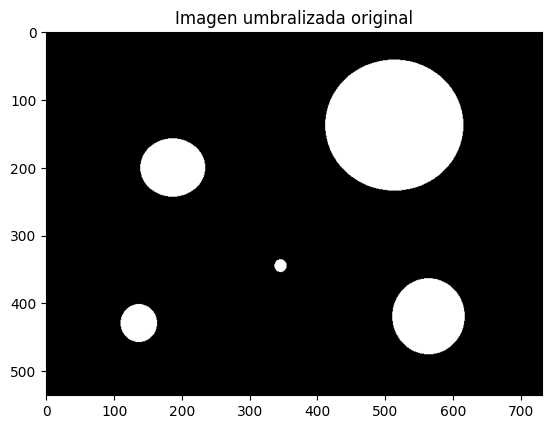

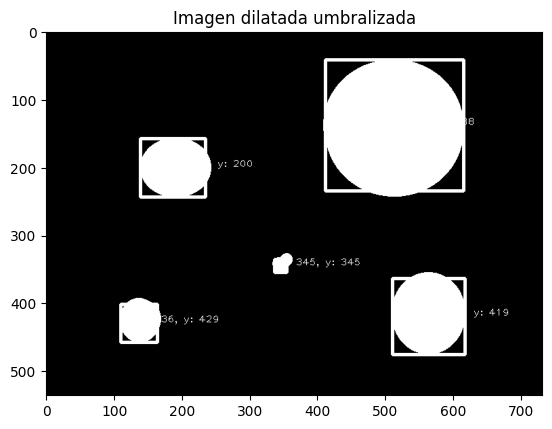

In [ ]:
imagen = cv2.imread('xd2.png') #cargar la imagen original
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY) #A escala de grises


ret, img_th= cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV) #se umbraliza la imagen y se guarda en th

plt.figure(2); plt.imshow(img_th,cmap='gray'); plt.title("Imagen umbralizada original")

contornos,jerarquia=cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #se extraen los contornos de la imagen umbralizada
cXa,cYa,area=centroide_area(contornos,imagen)
img_dilatada=dilatacion_direc(cXa,cYa,area,contornos,imagen)



plt.figure(3); plt.imshow(img_dilatada,cmap='gray'); plt.title("Imagen dilatada umbralizada")


Se observa en este ejemplo como la bola más grande es la que más atrae a los demás objetos, mientras que la bola pequeña no genera casi efecto en los otros. Para esta aplicación, se tuvo que multiplicar x3 el número de iteraciones de los parámetros vistos en clase, con el fin de poder visualizar mejor los resultados.

### Adelgazamiento

Este código implementa un proceso de adelgazamiento en imágenes binarias, un paso común en el procesamiento de imágenes para simplificar la representación de objetos mientras se conservan sus características importantes, como bordes y conectividad.

A continuación, se proporciona una explicación paso a paso del código y un análisis de por qué se realiza de esta manera:

* Se definen patrones específicos (elementos estructurales) que se buscan eliminar en la imagen.

* Se realizan rotaciones de estos patrones para considerar todas las orientaciones posibles.

* En un bucle, se aplican operaciones de "Hit-or-Miss" para buscar y eliminar estos patrones en la imagen.

* El bucle se repite hasta que la imagen no pueda adelgazarse más, lo que significa que se han eliminado todos los detalles no esenciales.

* La imagen resultante después de este proceso se devuelve como resultado.

El adelgazamiento se utiliza comúnmente en el procesamiento de imágenes para simplificar y reducir la complejidad de las representaciones binarias, lo que facilita tareas como el reconocimiento de patrones y la detección de objetos. Este enfoque particular utiliza elementos estructurales específicos y la operación "Hit-or-Miss" para eliminar gradualmente detalles no esenciales en la imagen mientras se conservan las características clave. El bucle se repite hasta que no se puedan realizar más adelgazamientos, lo que garantiza que se alcance un estado mínimo de la imagen.

In [ ]:
def adelgazar(img):
    h1 = np.array([[0, 0, 0],[0, 1, 0],[1, 1, 1]])#Elimincación bordes
    m1 = np.array([[1, 1, 1],[0, 0, 0],[0, 0, 0]])
    h2 = np.array([[0, 0, 0],[1, 1, 0],[0, 1, 0]])#Eliminación bordes
    m2 = np.array([[0, 1, 1],[0, 0, 1],[0, 0, 0]])
    hit_list = []
    miss_list = []
    for k in range(4):
        hit_list.append(np.rot90(h1, k))#rotar h1
        hit_list.append(np.rot90(h2, k))#rotar h2
        miss_list.append(np.rot90(m1, k))#rotar m1
        miss_list.append(np.rot90(m2, k))#rotar m2
    while True:
        last = img
        for hit, miss in zip(hit_list, miss_list):
            hm = m.binary_hit_or_miss(img, hit, miss).astype(int)
            img = np.logical_and(img, np.logical_not(hm))
        if np.all(img == last):
            break
    return img

<ipython-input-4-a650cbb9c436>:16: DeprecationWarning: Please use `binary_hit_or_miss` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  hm = m.binary_hit_or_miss(img, hit, miss).astype(int)


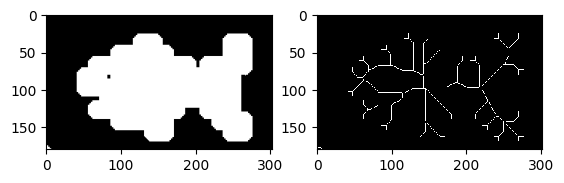

In [ ]:
a = np.zeros((50, 50), dtype=int)
a[10:40, 10:40] = 1
a[15:35, 15:35] = 0

img1 = cv2.imread('pez.jpeg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) #A escala de grises
h,img = cv2.threshold(img1,200,255,cv2.THRESH_BINARY_INV)

plt.subplot(121)
img=255-img
k3 = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
img_d = cv2.dilate(img,k3,iterations = 3)

plt.imshow(img_d, cmap='gray')
skell = adelgazar(img_d)
plt.subplot(122)
plt.imshow(skell, cmap="gray", interpolation="nearest")
plt.show()

Se observa que los resultados del algoritmo de adelgazamiento son muy buenos, sin embargo, se observa que se pierde algunas uniones del pez, sobre todo separando el cuerpo de la cola.